# Gender_Face_Machine

### epochs: 15
### Train_Batch_size: 100
### Test_Batch_size: 340
### Full_image_size: 32000(1600_image * augmentaion(20))
### Total_Training_Time: 32000(Image_size) * Epochs(15)

In [1]:
epochs = 15
batch_size = 100
Full_image_size = 32000

### Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import random
import cv2

## Train/Test Image Path

In [3]:
gender_path = "/Users/changmin.kim/Desktop/jupyterNotebook/Hands_on_Machine_Learning/datasets/gender_face/"

In [4]:
train_path = os.path.join(gender_path,"train")

In [5]:
print("train주소:",train_path)

train주소: /Users/changmin.kim/Desktop/jupyterNotebook/Hands_on_Machine_Learning/datasets/gender_face/train


In [6]:
test_path = os.path.join(gender_path,"test")

In [7]:
print("test주소:",test_path)

test주소: /Users/changmin.kim/Desktop/jupyterNotebook/Hands_on_Machine_Learning/datasets/gender_face/test


## Bring Train Test Image And Augmentation

In [8]:
image_generator = ImageDataGenerator(
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    zoom_range=[1,1.3],
    rotation_range=15,
    fill_mode='constant',
    width_shift_range=20,
    height_shift_range=20,
    brightness_range=(0.1,1),# 밝기를 설정하면 정규화가 더욱 잘된다. # 이유는 모르겠다.
    cval=0)

In [9]:
face_train_image = image_generator.flow_from_directory(
    train_path,
    shuffle=True,
    color_mode="grayscale",
    target_size=(160,160),
    batch_size=100,
    class_mode="binary")

Found 1600 images belonging to 2 classes.


In [10]:
print("Image 타입:",face_train_image[0][0][0].dtype)
print("Target 타입:",face_train_image[0][0][0].dtype)

Image 타입: float32
Target 타입: float32


In [11]:
face_test_image = image_generator.flow_from_directory(
    test_path,
    shuffle=True,
    color_mode="grayscale",
    target_size=(160,160),
    batch_size=340,
    class_mode="binary")

Found 340 images belonging to 2 classes.


## resizing

In [12]:
x = face_train_image[0][0]

In [13]:
x.shape

(100, 160, 160, 1)

In [14]:
def resizing(x,x_size,y_size):
    """
    x는 배치 데이터로 해야된다.(batch,x,y,channel(흑백=1))
    x_size: resize할 x크기
    y_size: resize할 y크기
    """
    copy = np.zeros((len(x),x_size,y_size)).astype('float32')
    for i in range(len(x)):
        copy[i] = cv2.resize(x[i][:,:,0],(x_size,y_size))
    copy = np.expand_dims(copy,3)
    return copy

In [15]:
new_x = resizing(x,80,80)
print(new_x.dtype)

float32


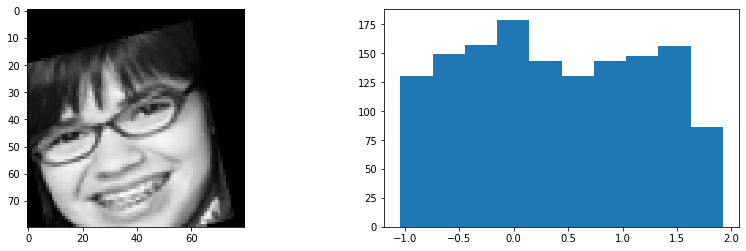

In [16]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
i = random.randint(0,batch_size-1)
plt.imshow(new_x[i][:,:,0],'gray')

plt.subplot(1,2,2)
plt.hist(np.unique(new_x[i][:,:,0]),bins=10)
plt.show()

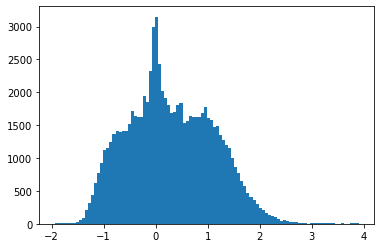

In [17]:
plt.hist(np.unique(new_x),bins=100)
plt.show()

#### 전체 데이터셋 히스토그램
- 전반적으로 정규화 형식이 나타난다.

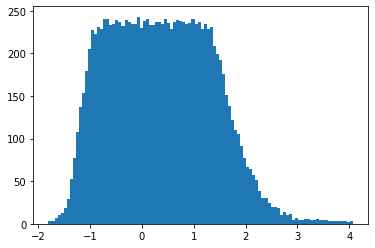

In [18]:
plt.hist(np.unique(face_train_image[0][0]),bins=100)
plt.show()

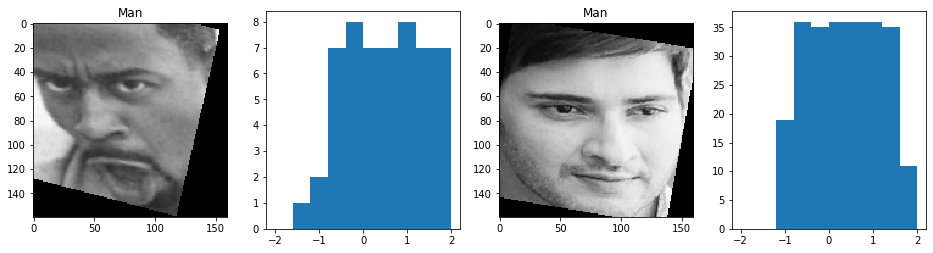

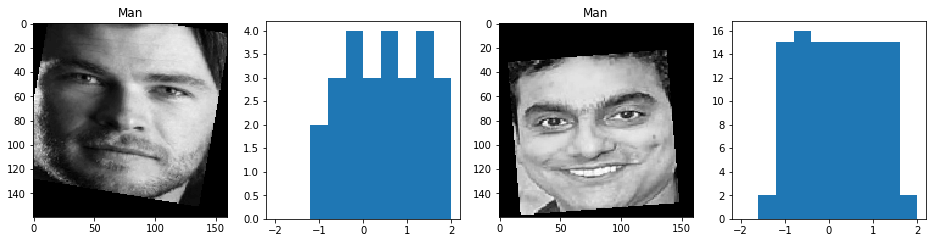

In [19]:
randomInt = random.randint(0,95)
gender_dic = {0:"Man",1:"Girl"}
height = face_train_image[0][0][0].shape[0]
width = face_train_image[0][0][0].shape[1]

plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.title(gender_dic[face_train_image[0][1][randomInt]])
plt.imshow(face_train_image[0][0][randomInt].reshape(height,width),'gray')
plt.subplot(1,4,2)
plt.hist(np.unique(face_train_image[0][0][randomInt].ravel()),range=(-2,2))


plt.subplot(1,4,3)
plt.title(gender_dic[face_train_image[0][1][randomInt+1]])
plt.imshow(face_train_image[0][0][randomInt+1].reshape(height,width),'gray')
plt.subplot(1,4,4)
plt.hist(np.unique(face_train_image[0][0][randomInt+1].ravel()),range=(-2,2))
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(2,4,1)
plt.title(gender_dic[face_train_image[0][1][randomInt+2]])
plt.imshow(face_train_image[0][0][randomInt+2].reshape(height,width),'gray')
plt.subplot(2,4,2)
plt.hist(np.unique(face_train_image[0][0][randomInt+2].ravel()),range=(-2,2))


plt.subplot(2,4,3)
plt.title(gender_dic[face_train_image[0][1][randomInt+3]])
plt.imshow(face_train_image[0][0][randomInt+3].reshape(height,width),'gray')
plt.subplot(2,4,4)
plt.hist(np.unique(face_train_image[0][0][randomInt+3].ravel()),range=(-2,2))
plt.show()

## Convolution Layer

#### Pytorch image shape
- batch_size, channel num, height, width

In [20]:
image = face_train_image[0][0][0].reshape(1,height,width,1)

In [21]:
image.shape

(1, 160, 160, 1)

In [22]:
image = np.transpose(image,axes=(0,3,1,2))

In [23]:
cnn_layer = nn.Conv2d(in_channels=1,out_channels=20,kernel_size=5).to(torch.device('cpu'))

In [24]:
weight = cnn_layer.weight
print(weight.shape)

torch.Size([20, 1, 5, 5])


In [25]:
weight_detach = weight.detach().numpy()

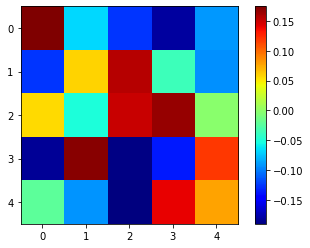

In [26]:
plt.imshow(weight_detach[0,0,:,:],'jet')
plt.colorbar()
plt.show()

In [27]:
output_image = cnn_layer(torch.from_numpy(image))

In [28]:
output_image = output_image.data

In [29]:
output_data = output_image.cpu().numpy()

In [30]:
image[0,0,:,:].shape

(160, 160)

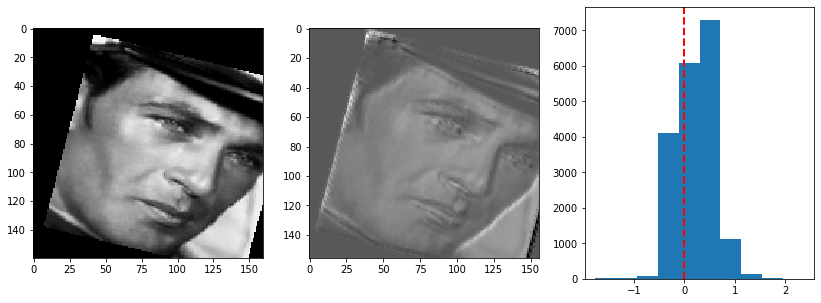

In [31]:
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(image[0,0,:,:],'gray')
plt.subplot(1,3,2)
plt.imshow(output_data[0,11,:,:],'gray')
plt.subplot(1,3,3)
plt.hist(np.unique(output_data[0,11,:,:]))
plt.axvline(0,color='r',linestyle='--',lw=2.0)
plt.show()

## Activation Function

In [32]:
relu_layer = F.relu(output_image)

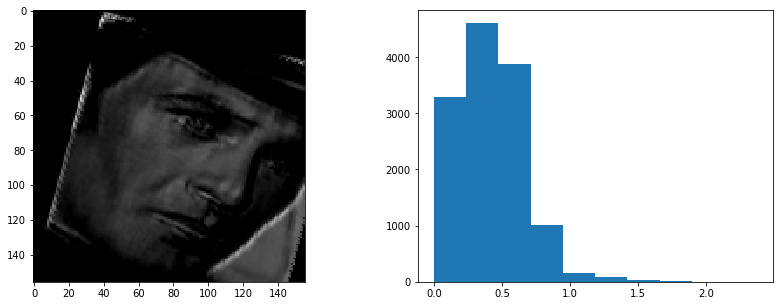

In [33]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(relu_layer[0,11,:,:],'gray')
plt.subplot(1,2,2)
plt.hist(np.unique(relu_layer[0,11,:,:]))
plt.show()

## Pooling Layer

In [34]:
pool_layer = F.max_pool2d(relu_layer,2,2)

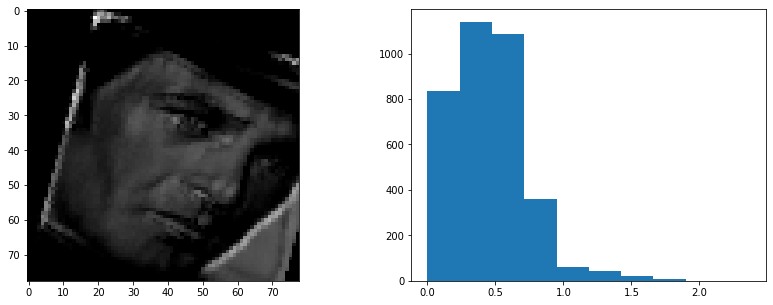

In [35]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(pool_layer[0,11,:,:],'gray')
plt.subplot(1,2,2)
plt.hist(np.unique(pool_layer[0,11,:,:]))
plt.show()

## Model

In [36]:
"""
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,3,8)
        self.conv2 = nn.Conv2d(3,64,5)
        self.conv3 = nn.Conv2d(64,128,3)
        
        self.fc1 = nn.Linear(128*7*7,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,2)


        
    def forward(self, x):
        # layer1
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x,2,2)

        # layer2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)

        # layer3
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        
        x = x.view(-1,128*7*7)
        #layer4
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p=0.3)
        #layer5
        x = F.relu(self.fc2(x))
        x = F.dropout(x,p=0.3)
        #layer6
        x = F.relu(self.fc3(x))
        x = F.dropout(x,p=0.3)
        #layer7
        x = self.fc4(x)
        
        return F.log_softmax(x)#따로 log를 안 취해주어도 된다.
"""

'\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net,self).__init__()\n        self.conv1 = nn.Conv2d(1,3,8)\n        self.conv2 = nn.Conv2d(3,64,5)\n        self.conv3 = nn.Conv2d(64,128,3)\n        \n        self.fc1 = nn.Linear(128*7*7,1024)\n        self.fc2 = nn.Linear(1024,512)\n        self.fc3 = nn.Linear(512,128)\n        self.fc4 = nn.Linear(128,2)\n\n\n        \n    def forward(self, x):\n        # layer1\n        x = F.relu(self.conv1(x))\n        x = F.avg_pool2d(x,2,2)\n\n        # layer2\n        x = F.relu(self.conv2(x))\n        x = F.max_pool2d(x,2,2)\n\n        # layer3\n        x = F.relu(self.conv3(x))\n        x = F.max_pool2d(x,2,2)\n        \n        x = x.view(-1,128*7*7)\n        #layer4\n        x = F.relu(self.fc1(x))\n        x = F.dropout(x,p=0.3)\n        #layer5\n        x = F.relu(self.fc2(x))\n        x = F.dropout(x,p=0.3)\n        #layer6\n        x = F.relu(self.fc3(x))\n        x = F.dropout(x,p=0.3)\n        #layer7\n        x = se

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,3,8)
        self.conv2 = nn.Conv2d(3,64,5)
        self.conv3 = nn.Conv2d(64,128,3)
        
        self.fc1 = nn.Linear(128*7*7,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,2)


        
    def forward(self, x, i):
        # layer1
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x,2,2)
        plt.figure(figsize=(15,4))
        
        if(i%80!=0):
            plt.close()
        # Image aspect
        if(i%80==0):
            data = x.data
            plt.subplot(1,3,1)
            plt.title(data.shape)
            plt.imshow(data[0,0,:,:],'gray')
            plt.colorbar()
        

        # layer2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        
        # Image aspect
        if(i%80==0):
            data = x.data
            plt.subplot(1,3,2)
            plt.title(data.shape)
            plt.imshow(data[0,0,:,:],'gray')
            plt.colorbar()
        
        # layer3
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        
        # Image aspect
        if(i%80==0):
            data = x.data
            plt.subplot(1,3,3)
            plt.title(data.shape)
            plt.colorbar()
            plt.imshow(data[0,0,:,:],'gray')
            
        
        
        x = x.view(-1,128*7*7)
        #layer4
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p=0.3)
        #layer5
        x = F.relu(self.fc2(x))
        x = F.dropout(x,p=0.3)
        #layer6
        x = F.relu(self.fc3(x))
        x = F.dropout(x,p=0.3)
        #layer7
        x = self.fc4(x)
        
        # Image Result
        if(i%80==0):
            plt.show()
        
        return F.log_softmax(x)#따로 log를 안 취해주어도 된다.

In [38]:
test_model = Net().cpu()

In [39]:
i = random.randint(0,99)
random_one_image = np.transpose(np.expand_dims(new_x[i],0),axes=(0,3,1,2))

In [40]:
random_one_image.shape

(1, 1, 80, 80)

In [41]:
new_x[i].shape

(80, 80, 1)

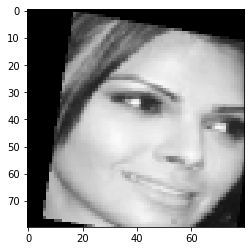

In [42]:
plt.imshow(np.squeeze(new_x[i]),'gray')

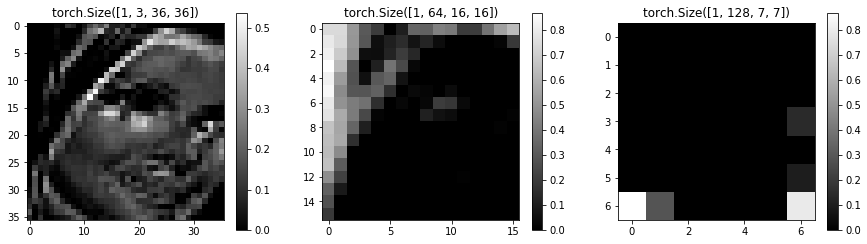

/Users/changmin.kim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-0.6728, -0.7139]], grad_fn=<LogSoftmaxBackward>)

In [43]:
test_model(torch.from_numpy(random_one_image),80)

## Model 객체 생성

In [44]:
model = Net().cpu()

## The Number of Training Weight 
#### layer1: weight: [3, 1, 8, 8], bias: [3]
#### layer2: weight: [64, 3, 5, 5], bias: [64]
#### layer3: weight: [128, 64, 3, 3], bias: [64]
#### layer4: weight: [1024, 6272], bias: [1024]
#### layer5: weight: [512, 1024], bias: [512]
#### layer6: weight: [128, 512], bias: [128]
#### layer7: weight: [2, 128], bias: [2]

In [45]:
params = list(model.parameters())
for i in range(len(params)):
    if i%2==0:
        print("weight:",params[i].shape)
        
    else:
        print("bias:",params[i].shape)
        print('')

weight: torch.Size([3, 1, 8, 8])
bias: torch.Size([3])

weight: torch.Size([64, 3, 5, 5])
bias: torch.Size([64])

weight: torch.Size([128, 64, 3, 3])
bias: torch.Size([128])

weight: torch.Size([1024, 6272])
bias: torch.Size([1024])

weight: torch.Size([512, 1024])
bias: torch.Size([512])

weight: torch.Size([128, 512])
bias: torch.Size([128])

weight: torch.Size([2, 128])
bias: torch.Size([2])



### The Total Number of Weight : 7,091,328(7million)

In [46]:
3*1*8*8 + 64*3*5*5 + 128*64*3*3 + 1024*6272 + 512*1024 + 128*512 + 2*128

7091328

## Before Training

In [47]:
model.train()

Net(
  (conv1): Conv2d(1, 3, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [49]:
data, target = next(iter(face_train_image))
data, target = torch.from_numpy(data), torch.from_numpy(target)

In [50]:
data, target = data.to(device), target.to(device)

In [51]:
data.shape

torch.Size([100, 160, 160, 1])

In [52]:
target
# pytorch에서 nll_loss는 target은 onehot이 아니라 index번호로 해야한다.

tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 1., 1., 0., 0.])

## Optimizer
- AdamOptimizer를 사용

### learning_rate 

In [53]:
learning_rate = 0.001

In [54]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

## Start Training And Evaluating


### test_epoch: 17

In [55]:
log_interval = 80
test_epoch = 34

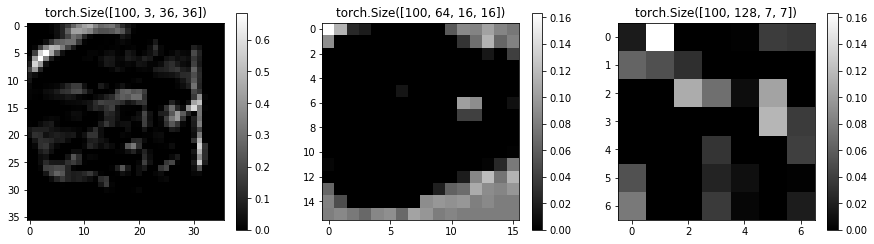

/Users/changmin.kim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/32000 (0%)]	Loss: 0.695150


KeyboardInterrupt: 

In [56]:
for epoch in range(1,epochs+1):
    model.train() # Train Mode (Using Batch Normalize ,dropout, and etc.)
    for batch_idx in range(int(Full_image_size/batch_size)):
        data, target = next(iter(face_train_image))
        data = np.transpose(resizing(data,80,80),axes=(0,3,1,2))
        
        target = target.astype('int64')
        data, target = torch.from_numpy(data), torch.from_numpy(target)
        data, target = data.to(device), target.to(device)

        model.zero_grad()
        output = model(data,batch_idx)
        loss = F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), Full_image_size,
                (batch_idx / (Full_image_size/100))*100, loss.item()
            ))
            
    test_loss = 0
    correct = 0
    
    model.eval() # Test Mode (Not Using Batch Normalize ,dropout, and etc.)
    
    with torch.no_grad():
        for i in range(test_epoch):
            data, target = next(iter(face_test_image))
            data = np.transpose(resizing(data,80,80),axes=(0,3,1,2))

            target = target.astype('int64')
            data, target = torch.from_numpy(data), torch.from_numpy(target)
            data, target = data.to(device), target.to(device)

            output = model(data,1)
            test_loss += F.nll_loss(output,target)
            pred = output.argmax(dim=1, keepdim=True)# 0차원은 바뀌지 않게 한다.
            correct += (pred.eq(target.view_as(pred)).sum().item())/batch_size
        test_loss = test_loss/test_epoch
        correct = correct*100/test_epoch
        print("Test set: Average Loss: {:4f}, Accuracy: {}%".format(test_loss, correct))
        
    if(correct>=96):
        print("Training Exit")
        break

## Accuracy In Total Test 

In [60]:
correct = 0
test_loss = 0

model.eval()
with torch.no_grad():
    
    data, target = next(iter(face_test_image))
    data = np.transpose(resizing(data,80,80),axes=(0,3,1,2))

    target = target.astype('int64')
    data, target = torch.from_numpy(data), torch.from_numpy(target)
    data, target = data.to(device), target.to(device)

    output = model(data,1)
    test_loss = F.nll_loss(output,target)
    pred = output.argmax(dim=1, keepdim=True)# 0차원은 바뀌지 않게 한다.
    correct = (pred.eq(target.view_as(pred)).sum().item())/340
    print("Test set: Average Loss: {:4f}, Accuracy: {}%".format(test_loss, correct))

Test set: Average Loss: 0.155061, Accuracy: 0.9411764705882353%


/Users/changmin.kim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Torch Model Save

- savePath = "/Users/changmin.kim/Desktop/jupyterNotebook/model/gender_face_model.pt"
- torch.save(model.state_dict(), savePath)

In [56]:
gender = {0:'Male',1:'Girl'}

## Torch Model Load

In [57]:
loadPath = '/Users/changmin.kim/Desktop/jupyterNotebook/model/gender_face_model.pt'

In [58]:
checkpoint = torch.load(loadPath)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [59]:
model

Net(
  (conv1): Conv2d(1, 3, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

## The Machine is  distinguishing Image to male or female

In [322]:
error_image = []
error_name = []

In [333]:
face_test_image[0][0].shape

(340, 160, 160, 1)

/Users/changmin.kim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


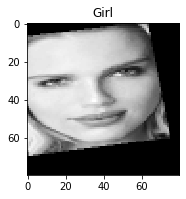

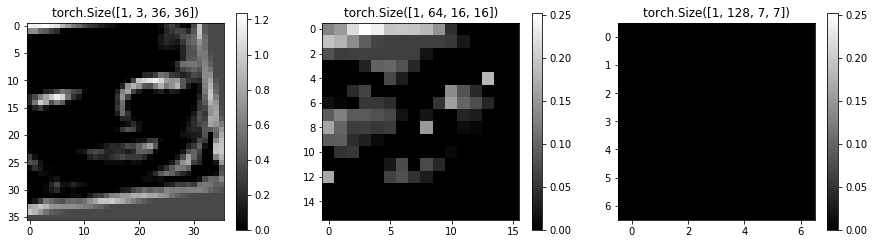

예측: Male


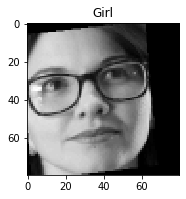

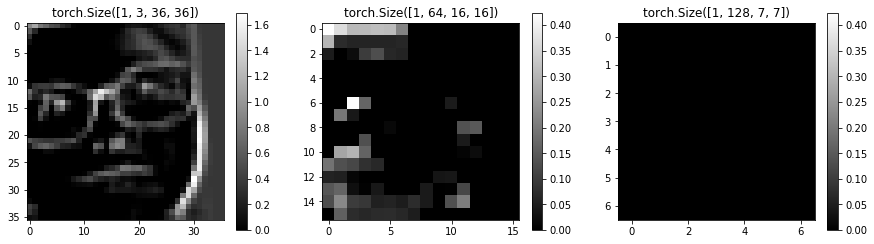

예측: Male


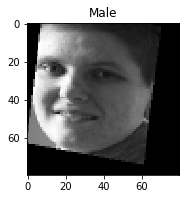

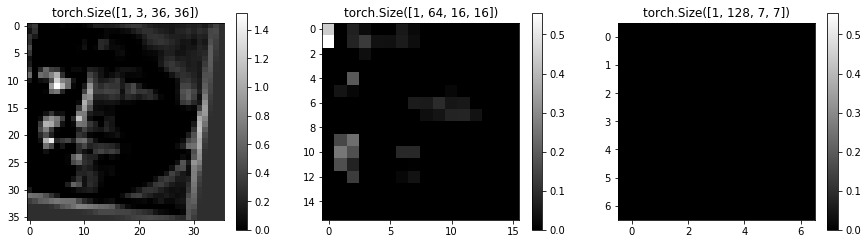

예측: Girl


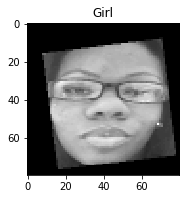

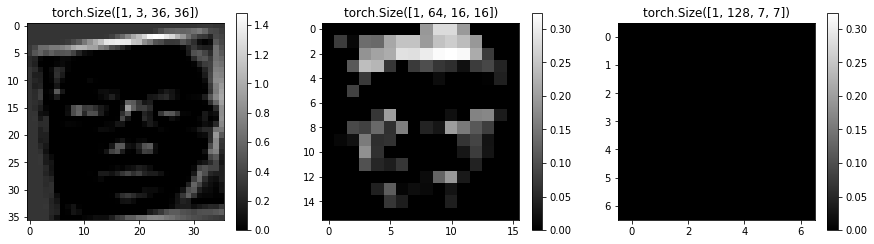

예측: Male


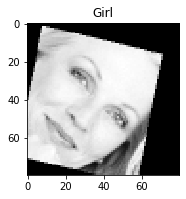

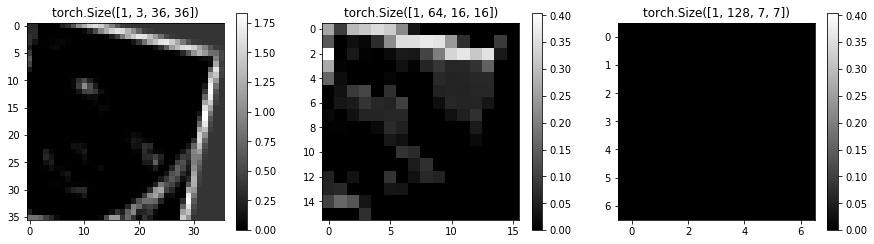

예측: Girl


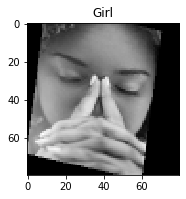

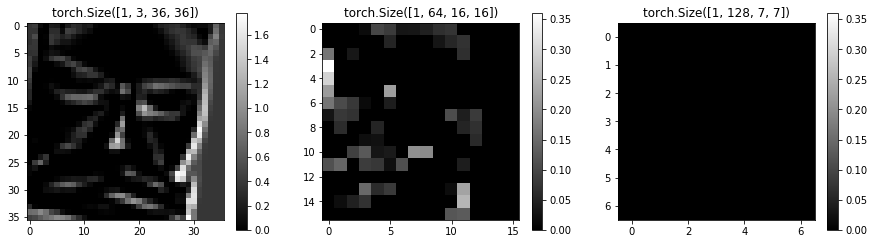

예측: Male


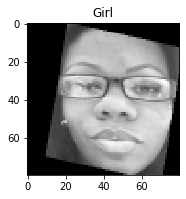

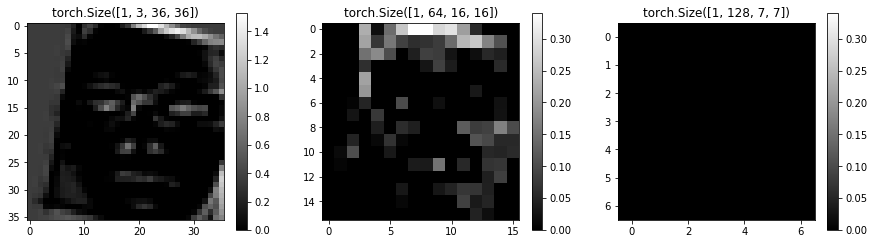

예측: Male


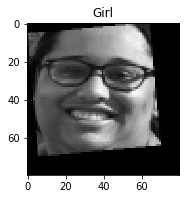

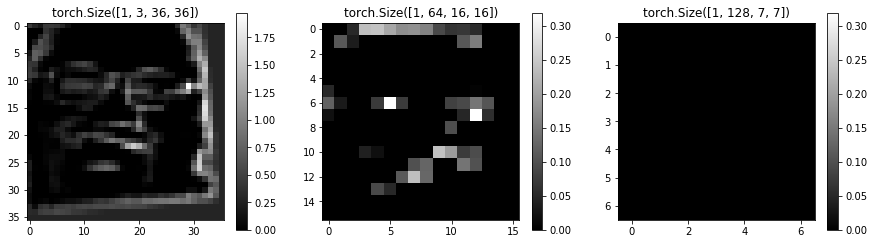

예측: Male


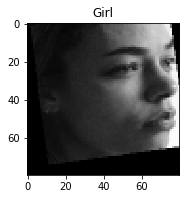

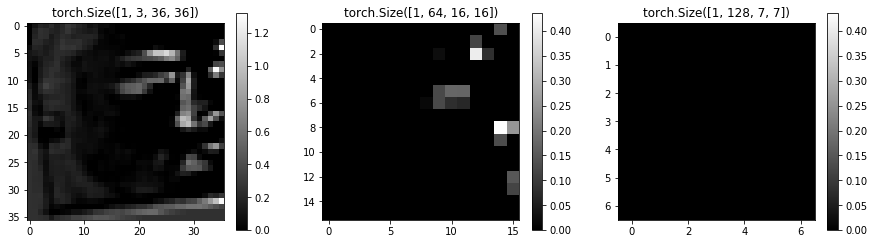

예측: Male


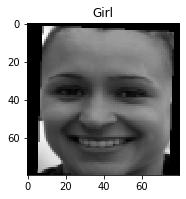

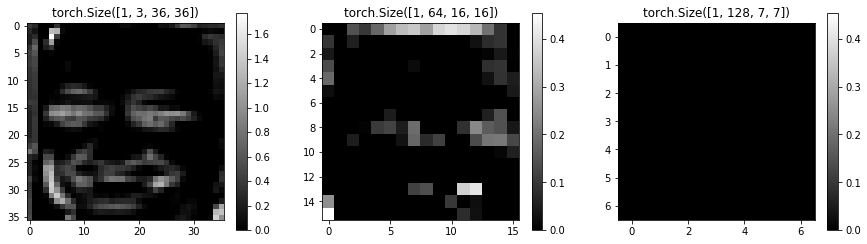

예측: Male


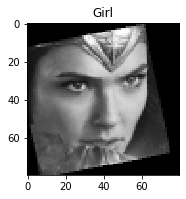

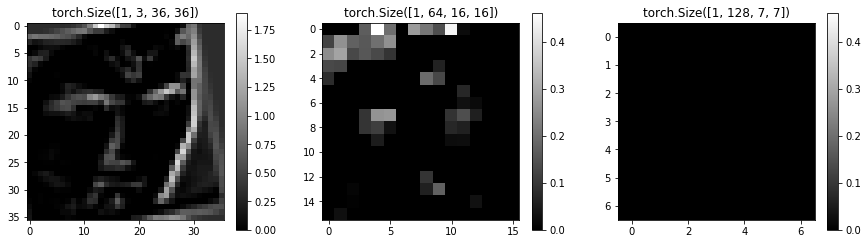

예측: Male


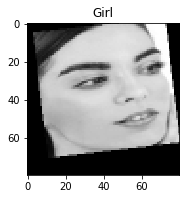

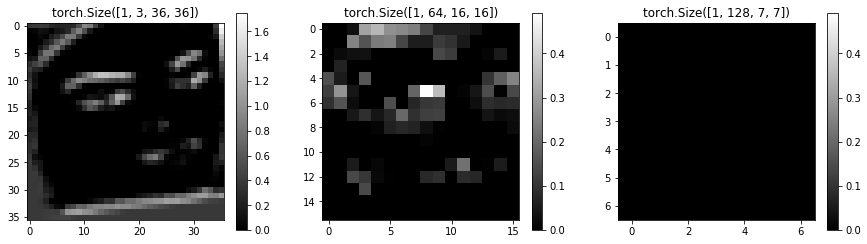

예측: Male


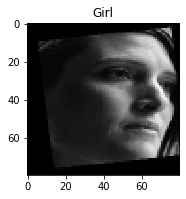

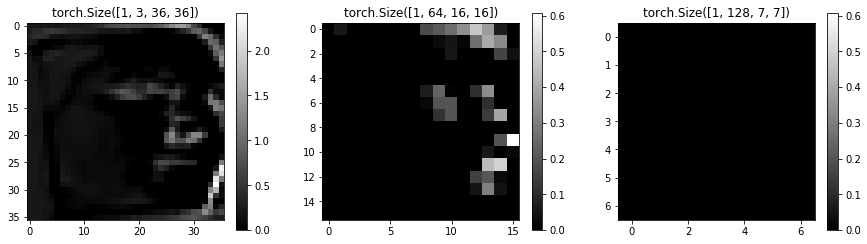

예측: Male


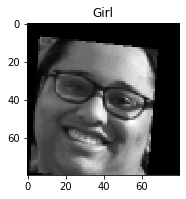

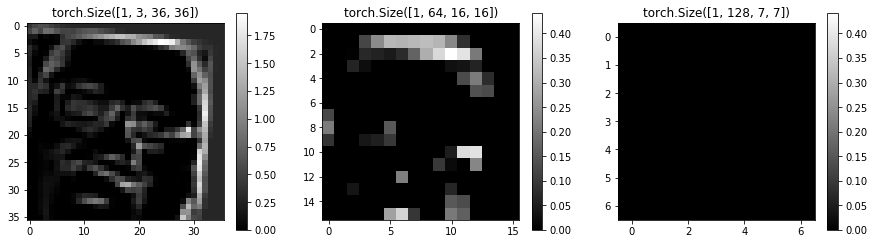

예측: Male


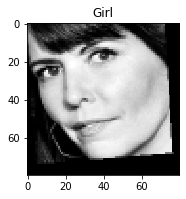

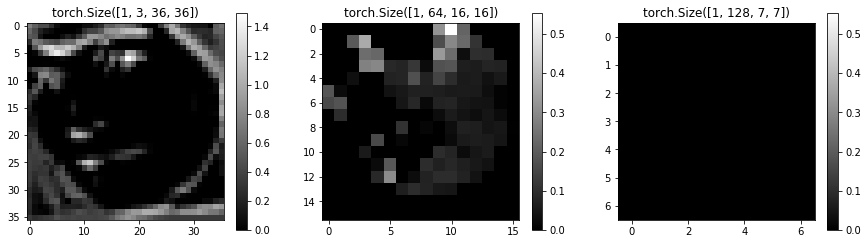

예측: Male


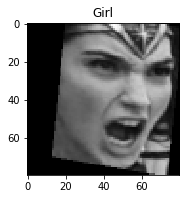

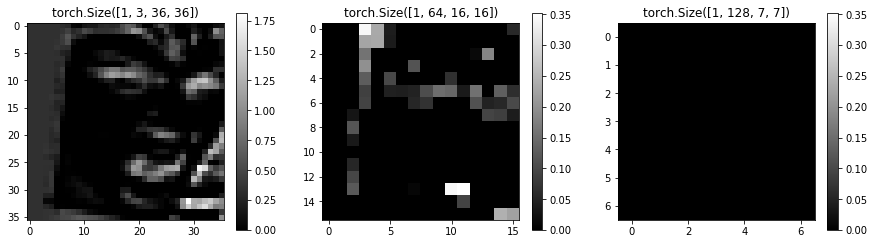

예측: Male


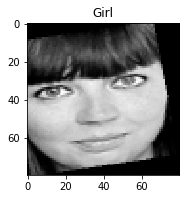

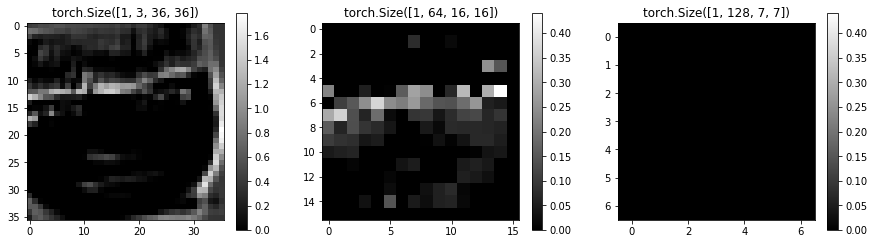

예측: Male


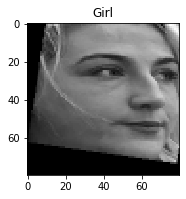

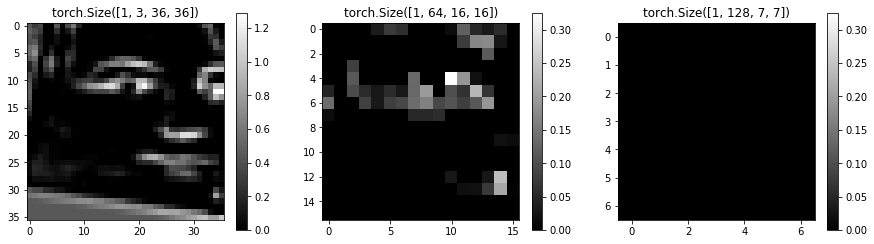

예측: Girl


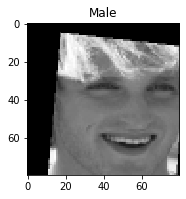

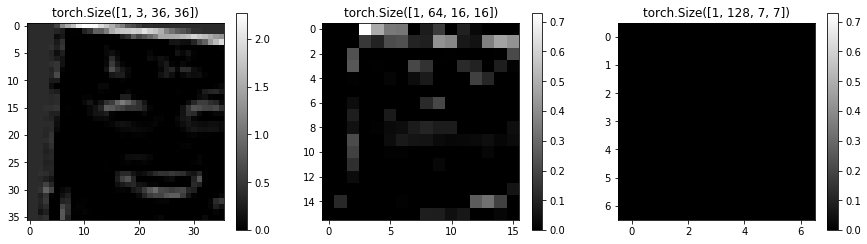

예측: Girl


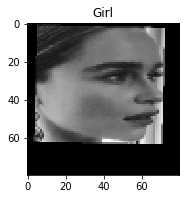

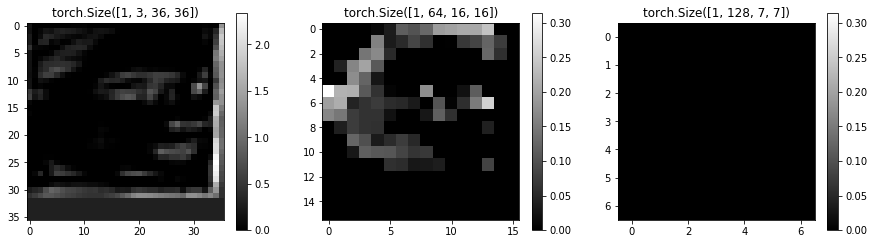

예측: Male


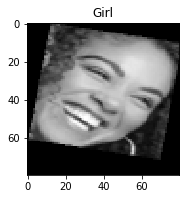

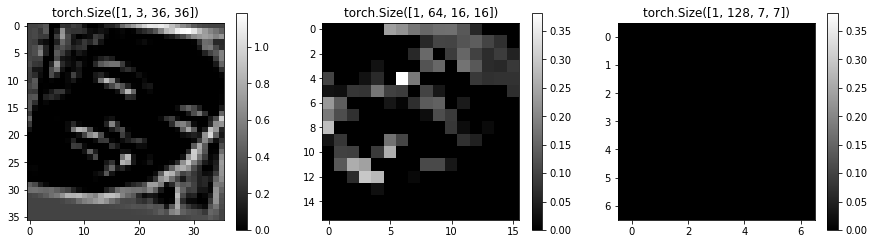

예측: Girl


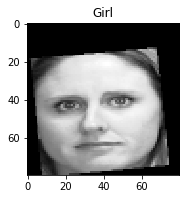

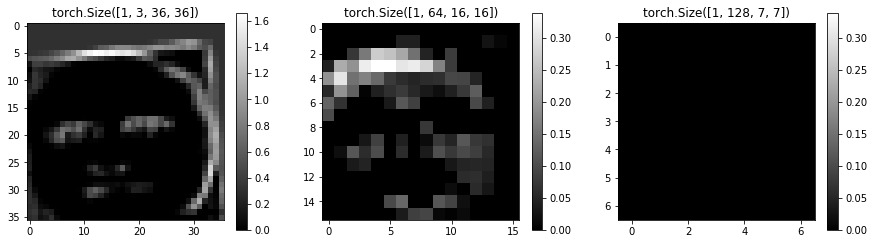

예측: Girl


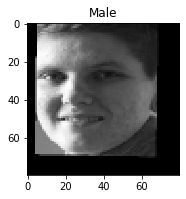

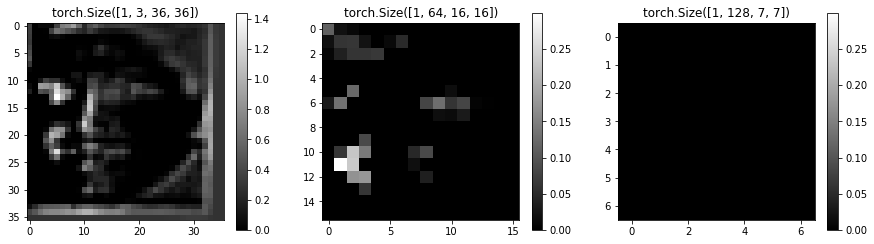

예측: Male


In [335]:
for i in range(300):
    nums = 0
    face_image,face_num = face_test_image[nums]
    

    num = random.randint(0,len(face_image)-1)
    face_image = np.expand_dims(face_image[num],0)
    face_image = resizing(face_image,80,80)

    face_num = face_num[num]

    random_face = np.transpose(face_image,axes=(0,3,1,2))
    
    
    n = model(torch.from_numpy(random_face),1)
    if(str(gender[face_num])!=gender[int(torch.argmax(n))]):
        error_image.append(random_face[0,0,:,:])
        
        plt.subplot(1,2,1)
        plt.imshow(face_image[0,:,:,0],'gray')
        plt.title(str(gender[face_num]))
        plt.show()
        
        n = model(torch.from_numpy(random_face),80)
        print("예측:",gender[int(torch.argmax(n))])
        if(int(torch.argmax(n)==1)):
            error_name.append('female')
        else:
            error_name.append('male')
            

## Error Image

In [61]:
print("에러 개수",len(error_image))

NameError: name 'error_image' is not defined

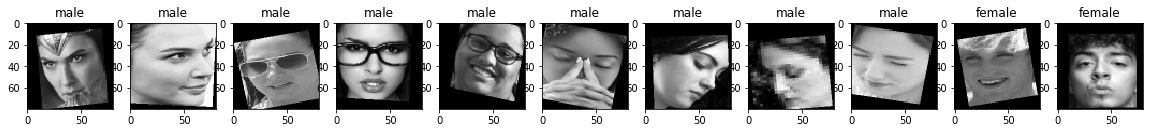

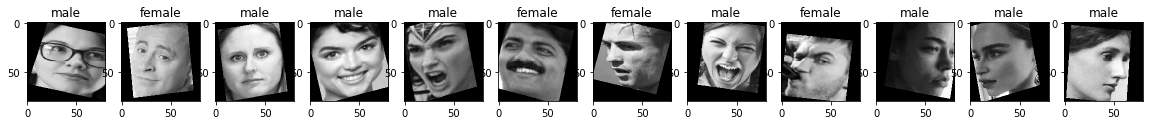

In [216]:
plt.figure(figsize=(20,4))
for i in range(0,11):
    plt.subplot(1,11,i+1)
    plt.title(str(error_name[i]))
    plt.imshow(error_image[i],'gray')
plt.show()

plt.figure(figsize=(20,4))
for i in range(11,23):
    plt.subplot(1,12,i - 10)
    plt.title(str(error_name[i]))
    plt.imshow(error_image[i],'gray')
plt.show()

In [68]:
def image_function(path):
    final_image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    while True:
        if(int(final_image.shape[0])/2<160):
            final_image = cv2.resize(final_image,(160,160))
            break
        final_image = cv2.resize(final_image,(int(final_image.shape[1]/2),int(final_image.shape[0]/2)))
        print(type(final_image))
        print(final_image.shape)

    final_image = np.expand_dims(final_image,axis=2)
    print(type(final_image))
    print(final_image.shape)

    final_image = np.expand_dims(final_image,axis=0)
    print(type(final_image))
    print(final_image.shape)

    final_image = resizing(final_image,80,80)
    print(type(final_image))
    print(final_image.shape)

    final_image = np.transpose(final_image,axes=(0,3,1,2))
    print(type(final_image))
    print(final_image.shape)
    return final_image

In [80]:
path = "/Users/changmin.kim/Desktop/mom.jpeg"

In [81]:
people = image_function(path)

<class 'numpy.ndarray'>
(929, 656)
<class 'numpy.ndarray'>
(464, 328)
<class 'numpy.ndarray'>
(232, 164)
<class 'numpy.ndarray'>
(160, 160, 1)
<class 'numpy.ndarray'>
(1, 160, 160, 1)
<class 'numpy.ndarray'>
(1, 80, 80, 1)
<class 'numpy.ndarray'>
(1, 1, 80, 80)


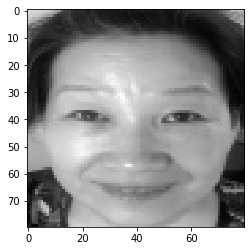

In [82]:
plt.imshow(people[0,0,:,:],'gray')
plt.show()

## The Robot cannot distinguish men who look like women well.

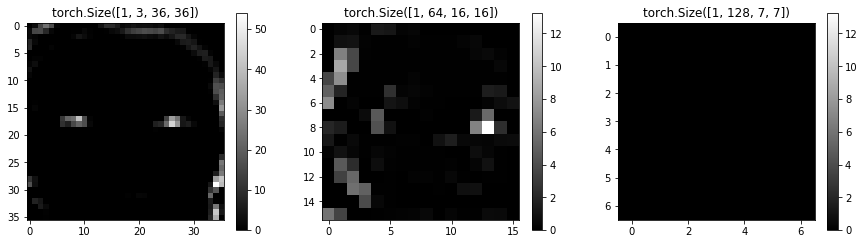

(1, 1, 80, 80)


/Users/changmin.kim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


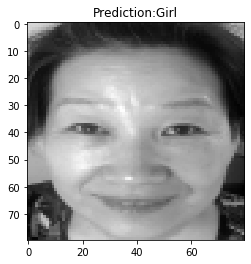

In [83]:
with torch.no_grad():
    model.eval()
    data = model(torch.from_numpy(people),80)
    print(people.shape)
    plt.title('Prediction:'+str(gender[int(torch.argmax(data))]))
    plt.imshow(people[0,0,:,:],'gray')
    plt.show()


## My Face Image

In [396]:
path = "/Users/changmin.kim/Desktop/jupyterNotebook/"
my_face = image_function(path)

<class 'numpy.ndarray'>
(859, 636)
<class 'numpy.ndarray'>
(429, 318)
<class 'numpy.ndarray'>
(214, 159)
<class 'numpy.ndarray'>
(160, 160, 1)
<class 'numpy.ndarray'>
(1, 160, 160, 1)
<class 'numpy.ndarray'>
(1, 80, 80, 1)
<class 'numpy.ndarray'>
(1, 1, 80, 80)


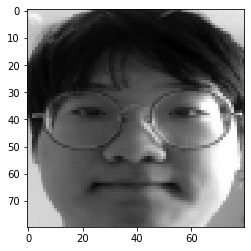

In [397]:
plt.imshow(my_face[0,0,:,:],'gray')

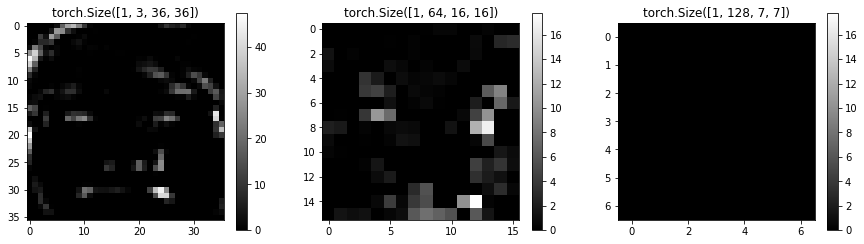

(1, 1, 80, 80)


/Users/changmin.kim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


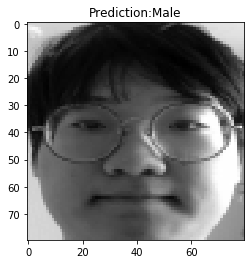

In [415]:
with torch.no_grad():
    model.eval()
    data = model(torch.from_numpy(my_face),80)
    print(my_face.shape)
    plt.title('Prediction:'+str(gender[int(torch.argmax(data))]))
    plt.imshow(my_face[0,0,:,:],'gray')
    plt.show()

## Result

- **The Mahine accuracy is 93% in Total Test Image.**<br>
- **Face Image Datasets(collected by me) have a littel Noise.(not hair)**<br>
- **The number of FacepImage is too small.**
- **A CNN parameters are somewhat short.**
- **If The Image filtered In First Cnn Layer is distinct, The Image is a high probability that it is correct.**<br>
- **There are more pictures of women among the Error(Error 74%: Female, Error 26%: Male).**
- **Some Augmention spoils a few Image(is cut off).**
- **Robots cannot distinguish men who look like women well.**